In [1]:
__author__ = 'Daisuke Yoda'
__Date__ = 'December 2018'

## Loading Modules

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from chainer import Chain, Variable, optimizers
import chainer.functions as F
import chainer.links as L
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')

## The LSTM Model

In [59]:
class LSTM(Chain):
    def __init__(self, in_size, hidden_size, hidden2_size, out_size):
        super(LSTM, self).__init__(
            xh=L.EmbedID(in_size, hidden_size),
            hh=L.LSTM(hidden_size, hidden2_size),
            hh2=L.Linear(hidden2_size, hidden2_size),
            hy=L.Linear(hidden2_size, out_size),
        )

    def __call__(self, x, t):
        x = Variable(x)
        t = Variable(t)

        h = self.xh(x)
        h = F.dropout(h,0.1)
        h = F.tanh(h)
        h = self.hh(h)
        h = self.hh2(h)
        h = F.dropout(h,0.1)
        y = F.relu(self.hy(h))

        return F.softmax_cross_entropy(y, t)

    def predict(self, x):
        x = Variable(x)

        h = self.xh(x)
        h = F.tanh(h)
        h = self.hh(h)
        h = self.hh2(h)
        h = F.relu(self.hy(h))
        y = F.softmax(h)

        return y.data

    def reset(self):
        self.hh.reset_state()

## Functions for arrangement

In [22]:
def padding(sentences):
    max_len = np.max([len(s) for s in sentences])
    paded_vec = []
    for sentence in sentences:
        pad_len = max_len - len(sentence)
        pad_vec = [26] * pad_len
        sentence.extend(pad_vec)
        paded_vec.append(sentence)

    return np.array(paded_vec,dtype=np.int32)

def one_hot_encoding(indices,n_class=27):
    return np.eye(n_class)[indices]

def word_to_index(word):
    word_index = [ord (char) - 97 for char in word]
    return word_index

## Preparing the dataset and convert it to vector expression

In [61]:
training_data = ['create', 'creative', 'creation', 'created', 'creating', 'creats', 'creater']
training_data = [word_to_index(x) for x in training_data]

## Defining the LSTM model and setting the optimizer

In [67]:
model = LSTM(27,50,10,27)
optimizer = optimizers.Adam()
optimizer.setup(model)

## Training

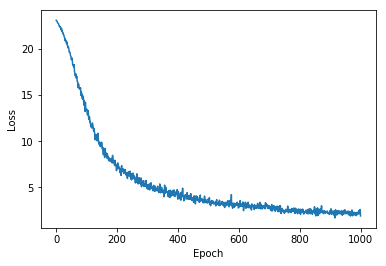

In [68]:
loss_record = []
for i in range(1000):
    model.reset()
    model.cleargrads()
    training_sample = deepcopy(np.random.permutation(training_data))
    training_sample = padding(training_data).T
    loss = 0
    trainX = training_sample[:-1]
    trainY = training_sample[1:]
    for X,Y in zip(trainX,trainY):
        loss += model(X,Y)

    loss_record.append(float(loss.data))
    loss.backward()
    optimizer.update()

plt.plot(loss_record)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [81]:
print({'c':1.0})

char = np.array(word_to_index('c'))
model.reset()
model.train = False

while True:
    y = model.predict(char)

    pred = np.apply_along_axis(chr,0, np.argsort(y) + 97)[::-1]
    pred = np.where(pred=='{','end',pred)
    prob = np.sort(y)[0][::-1]
    prob = np.round(prob,5)
    cadidate = [(char,p) for char,p in zip(pred[:3],prob[:3])]
    print(cadidate)

    char = np.array([np.argmax(y)], dtype=np.int32)

    if char[0] == 26:
        break

{'c': 1.0}
[('r', 0.99552), ('e', 0.00372), ('o', 0.00027)]
[('e', 0.99599), ('a', 0.00197), ('i', 0.00146)]
[('a', 0.9954), ('t', 0.00257), ('e', 0.0016)]
[('t', 0.99774), ('a', 0.00106), ('end', 0.00077)]
[('e', 0.43183), ('i', 0.42086), ('s', 0.13102)]
[('end', 0.33864), ('r', 0.31223), ('d', 0.30631)]
